In [45]:
#Import libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.svm import SVC, SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import GroupKFold, cross_val_predict, cross_val_score
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor


In [8]:
csv = '../lifespan_merged_datasets/mergedworms_companyDrug.csv'# Read the CSV file
data = pd.read_csv(csv)

np.random.seed(41)

## Lifespan Estimation

In [25]:
def predict_lifespan(data, model_select="linear", test_size=0.2, random_state=42):
    """
    Predict the lifespan of worms based on behavioral data.

    Args:
        df: DataFrame containing the dataset.
        model_select: Choice of regression model ('linear', 'random_forest', 'xgboost').
        test_size: Fraction of data to use as test set.
        random_state: Seed for reproducibility.

    Returns:
        None (prints evaluation metrics and feature importances for tree-based models).
    """
    df = data.copy()
    # csv = 'mergedworms.csv'# Read the CSV file
    # df = pd.read_csv(csv)


    # Preprocess lifespan (convert from hours to days)
    df['lifespan'] = df['lifespan'] / 24

    # Extract features (X), target (y), and groups (worm_id)
    # X = df.drop(columns=['id', 'worm_id', 'lifespan', 'average_distance_per_frame', 'maximal_distance_traveled', 'average_acceleration'])
    X = df.drop(columns = ['lifespan', 'worm_id']) #id
    if 'id' in df.columns:
        X = X.drop(columns = ['id'])
    print(X.columns)
    y = df['lifespan']
    groups = df['worm_id']
    

    # Split the dataset into training and testing based on worm_id grouping
    gkf = GroupKFold(n_splits=int(1 / test_size))
    train_idx, test_idx = next(gkf.split(X, y, groups))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #imputing
    if np.isnan(X_train).any().any() or np.isnan(X_test).any().any():
        # Impute missing values with the median
        imputer = SimpleImputer(strategy='median')
        X_train = imputer.fit_transform(X_train)
        X_test = imputer.fit_transform(X_test)

    # Initialize the model
    if model_select == "linear":
        model = LinearRegression()
    elif model_select == "random_forest":
        model = RandomForestRegressor(random_state=random_state)
    elif model_select == "xgboost":
        model = XGBRegressor(random_state=random_state, n_estimators=100, learning_rate=0.05)
    else:
        raise Exception("Invalid model selected. Options are 'linear', 'random_forest', 'xgboost'.")

    # Scale features for linear models
    if model_select == "linear":
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    # Train the model
    model.fit(X_train, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    # Feature importance for tree-based models
    if model_select in ["random_forest", "xgboost"]:
        importances = model.feature_importances_
        feature_importances = sorted(zip(X.columns, importances), key=lambda x: -x[1])
        print("\nFeature Importances:")
        for feature, importance in feature_importances:
            print(f"{feature}: {importance:.4f}")

    import matplotlib.pyplot as plt
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.xlabel("Actual Lifespan (days)")
    plt.ylabel("Predicted Lifespan (days)")
    plt.title("Predicted vs. Actual Lifespan")
    plt.show()

    print("y_pred max min", y_pred.max(), y_pred.min())
    print("y_test max min", y_test.max(), y_test.min())
    print("size: ", y_pred.size, y_test.size)

    return model, mse, r2

Index(['group', 'average_speed', 'average_distance_per_frame',
       'maximal_distance_traveled', 'average_change_in_pixels',
       'average_angular_speed', 'total_distance_traveled',
       'distance_traveled_bin', 'average_acceleration', 'time_elapsed_(hours)',
       'std_speed', 'std/mean', 'roaming_fraction', 'drugged'],
      dtype='object')
Mean Squared Error: 2.04
R^2 Score: 0.46


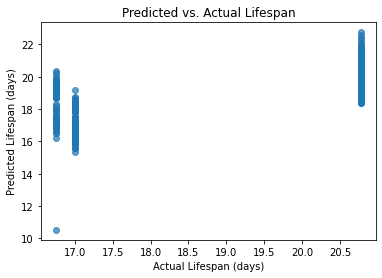

y_pred max min 22.752320457356742 10.523146246594855
y_test max min 20.770671296296296 16.754652777777782
size:  335 335


In [26]:
model, mse, r2 = predict_lifespan(data)

Index(['group', 'average_speed', 'average_distance_per_frame',
       'maximal_distance_traveled', 'average_change_in_pixels',
       'average_angular_speed', 'total_distance_traveled',
       'distance_traveled_bin', 'average_acceleration', 'time_elapsed_(hours)',
       'std_speed', 'std/mean', 'roaming_fraction', 'drugged'],
      dtype='object')
Mean Squared Error: 2.37
R^2 Score: 0.37

Feature Importances:
maximal_distance_traveled: 0.2078
total_distance_traveled: 0.1935
drugged: 0.1543
time_elapsed_(hours): 0.0826
distance_traveled_bin: 0.0759
roaming_fraction: 0.0617
group: 0.0428
average_angular_speed: 0.0340
std/mean: 0.0290
average_acceleration: 0.0268
average_change_in_pixels: 0.0252
average_speed: 0.0237
std_speed: 0.0233
average_distance_per_frame: 0.0195


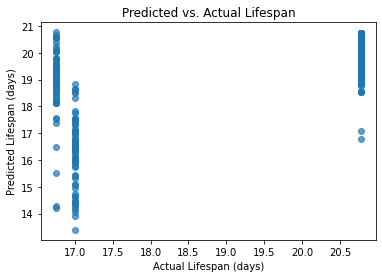

y_pred max min 20.76900555555557 13.387097222222213
y_test max min 20.770671296296296 16.754652777777782
size:  335 335


In [27]:
model, mse, r2 = predict_lifespan(data, model_select="random_forest")

Index(['group', 'average_speed', 'average_distance_per_frame',
       'maximal_distance_traveled', 'average_change_in_pixels',
       'average_angular_speed', 'total_distance_traveled',
       'distance_traveled_bin', 'average_acceleration', 'time_elapsed_(hours)',
       'std_speed', 'std/mean', 'roaming_fraction', 'drugged'],
      dtype='object')
Mean Squared Error: 2.17
R^2 Score: 0.43

Feature Importances:
drugged: 0.2744
maximal_distance_traveled: 0.2097
time_elapsed_(hours): 0.1583
distance_traveled_bin: 0.0914
roaming_fraction: 0.0527
group: 0.0406
std/mean: 0.0332
std_speed: 0.0315
average_speed: 0.0304
average_change_in_pixels: 0.0295
average_acceleration: 0.0262
average_angular_speed: 0.0219
average_distance_per_frame: 0.0000
total_distance_traveled: 0.0000


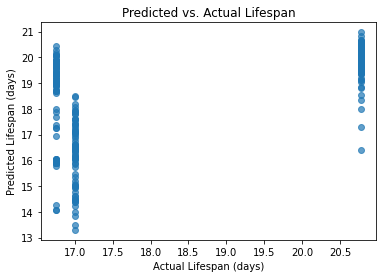

y_pred max min 20.974995 13.297626
y_test max min 20.770671296296296 16.754652777777782
size:  335 335


In [28]:
model, mse, r2 = predict_lifespan(data, model_select="xgboost")

In [17]:
csv = '../lifespan_merged_datasets/mergedworms_companyDrug.csv'# Read the CSV file
data = pd.read_csv(csv)

aggregated_data = data.groupby("worm_id").agg({
    "worm_id": "first",
    "group": "first",  # Assuming group is constant per worm
    "average_speed": ["mean", "median", "min", "max"],
    "maximal_distance_traveled": "max",  # Keep max as it may capture peaks
    "average_change_in_pixels": ["mean", "std", "median", "min", "max"],
    "average_angular_speed": ["mean", "std", "min", "max"],
    "distance_traveled_bin": ["std"],
    "time_elapsed_(hours)": "max",  # Keep max as it's likely cumulative
    "std_speed": "mean",  # Capture average variability
    "std/mean": "mean",  # Keep mean of std/mean as a ratio metric
    "roaming_fraction": "mean",  # Capture average roaming behavior
    "lifespan": "first",  # Lifespan is constant per worm
    "drugged": "first"  # Assuming drugged is constant per worm
})
aggregated_data.columns = ["_".join(col).strip() for col in aggregated_data.columns]
aggregated_data.rename(columns={"lifespan_first": "lifespan", "worm_id_first": "worm_id"}, inplace=True)

In [18]:
# aggregated_data.columns
aggregated_data['lifespan']

worm_id
1     354.497222
2     498.496111
3     498.496111
4     498.445000
5     498.496111
6     426.496667
7     498.167222
8     498.496111
9     336.460000
10    498.496111
11    468.167222
12    402.111667
37    498.496111
38    288.463889
39    324.222778
40    426.496667
41    462.389444
42    450.000556
43    414.222778
44    396.005000
45    420.278333
46    408.167222
47    450.000556
48    312.389444
Name: lifespan, dtype: float64

In [19]:
# Check for high correlation and avoid duplicates
# Iterate through the upper triangle of the correlation matrix (to avoid duplicates)
correlation_matrix = aggregated_data.corr()

# Threshold for high correlation
threshold = 0.75

for i in range(len(correlation_matrix.columns)):
    for j in range(i + 1, len(correlation_matrix.columns)):  # Upper triangle
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            correlation_value = correlation_matrix.iloc[i, j]
            print(f"Highly correlated: {col1} and {col2} with correlation {correlation_value:.2f}")

Highly correlated: worm_id and drugged_first with correlation -0.98
Highly correlated: average_speed_mean and average_speed_median with correlation 0.78
Highly correlated: average_speed_mean and maximal_distance_traveled_max with correlation 0.87
Highly correlated: average_speed_mean and distance_traveled_bin_std with correlation 0.80
Highly correlated: average_speed_mean and std_speed_mean with correlation 0.79
Highly correlated: average_speed_mean and lifespan with correlation -0.83
Highly correlated: average_speed_median and lifespan with correlation -0.81
Highly correlated: average_speed_max and distance_traveled_bin_std with correlation 0.97
Highly correlated: maximal_distance_traveled_max and distance_traveled_bin_std with correlation 0.79
Highly correlated: average_change_in_pixels_mean and average_change_in_pixels_max with correlation 0.91
Highly correlated: average_change_in_pixels_std and average_change_in_pixels_max with correlation 0.89
Highly correlated: average_angular_sp

Index(['group_first', 'average_speed_mean', 'average_speed_median',
       'average_speed_min', 'average_speed_max',
       'maximal_distance_traveled_max', 'average_change_in_pixels_mean',
       'average_change_in_pixels_std', 'average_change_in_pixels_median',
       'average_change_in_pixels_min', 'average_change_in_pixels_max',
       'average_angular_speed_mean', 'average_angular_speed_std',
       'average_angular_speed_min', 'average_angular_speed_max',
       'distance_traveled_bin_std', 'time_elapsed_(hours)_max',
       'std_speed_mean', 'std/mean_mean', 'roaming_fraction_mean',
       'drugged_first'],
      dtype='object')
Mean Squared Error: 5.07
R^2 Score: 0.55

Feature Importances:
average_speed_mean: 0.2270
average_speed_median: 0.1904
maximal_distance_traveled_max: 0.1288
average_speed_max: 0.0532
distance_traveled_bin_std: 0.0509
average_change_in_pixels_min: 0.0420
average_speed_min: 0.0381
std/mean_mean: 0.0360
average_angular_speed_mean: 0.0329
time_elapsed_(hours

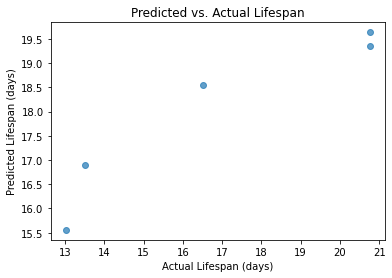

y_pred max min 19.636714814814816 15.557713194444448
y_test max min 20.770671296296296 13.016226851851853


In [20]:
model, mse, r2 = predict_lifespan(aggregated_data, model_select="random_forest")

In [21]:
csv2 = 'mergedworms_final.csv'# Read the CSV file
data2 = pd.read_csv(csv2)



FileNotFoundError: [Errno 2] File mergedworms_final.csv does not exist: 'mergedworms_final.csv'

In [29]:
data2.isna().sum()

Unnamed: 0                    0
group                         0
average_speed                 0
average_distance_per_frame    0
maximal_distance_traveled     0
average_change_in_pixels      0
average_angular_speed         0
distance_travaled             0
distance_travaled.1           0
average_change_speed          0
time_elapsed_(hours)          0
std_speed                     4
std/mean                      4
roaming_fraction              0
lifespan                      0
drugged                       0
worm_id                       0
dtype: int64

In [25]:
data2.shape

(312, 17)

In [85]:
def predict_lifespan2(data, model_select="linear", test_size=0.2, n_splits=5, n_repeats=3, random_state=42):
    """
    Predict the lifespan of worms using repeated GroupKFold cross-validation.

    Args:
        data: DataFrame containing the dataset.
        model_select: Regression model ('linear', 'random_forest', 'xgboost').
        test_size: Fraction for a single test fold size.
        n_splits: Number of splits for GroupKFold.
        n_repeats: Number of times to repeat K-Fold cross-validation.
        random_state: Seed for reproducibility.

    Returns:
        None (prints evaluation metrics, shows feature importances, and plots predictions).
    """
    df = data.copy()
    df["lifespan"] = df["lifespan"] / 24  # Convert lifespan to days

    # Extract features (X) and target (y)
    X = df.drop(columns=["id", "lifespan", "worm_id", "group"])  # Drop target and grouping columns #, "time_elapsed_(hours)", "group"
    if id in X.columns:
        X = X.drop(columns=["id"])
    y = df["lifespan"]
    groups = df["worm_id"]

    # Handle missing values
    imputer = SimpleImputer(strategy="median")
    X = imputer.fit_transform(X)

    # Scale features for linear regression
    if model_select == "linear":
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

    # Initialize model
    if model_select == "linear":
        model = LinearRegression()
    elif model_select == "random_forest":
        model = RandomForestRegressor(random_state=random_state)
    elif model_select == "xgboost":
        model = XGBRegressor(random_state=random_state, n_estimators=100, learning_rate=0.05)
    elif model_select == "elasticnet":
        model = ElasticNet()
    elif model_select == "svr":
        model = SVR()
    elif model_select == "knr":
        model = KNeighborsRegressor()
    else:
        raise ValueError("Invalid model selection. Choose 'linear', 'random_forest', or 'xgboost'.")

    # # Perform repeated GroupKFold cross-validation
    # gkf = GroupKFold(n_splits=n_splits)
    # y_pred = cross_val_predict(
    #     model, X, y, groups=groups, cv=gkf, method="predict"
    # )  # Generate predictions for all data points
    # Perform GroupKFold CV and collect predictions
    gkf = GroupKFold(n_splits=n_splits)
    preds_per_split = []
    for train_idx, test_idx in gkf.split(X, y, groups):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train = y.iloc[train_idx]

        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        preds_per_split.append((test_idx, preds))

    # Aggregate predictions and calculate std deviation
    pred_means = np.zeros(len(y))
    pred_stds = np.zeros(len(y))
    for test_idx, preds in preds_per_split:
        pred_means[test_idx] = preds
        pred_stds[test_idx] = np.std(preds)

    mse = mean_squared_error(y, pred_means)
    r2 = r2_score(y, pred_means)
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R^2 Score: {r2:.2f}")

    # Feature importance for linear models
    if model_select in ["linear", "elasticnet"]:
        model.fit(X, y)  # Fit the model
        feature_importances = sorted(zip(df.drop(columns=["lifespan", "worm_id"]).columns, model.coef_), key=lambda x: -abs(x[1]))
        print("\nFeature Importances (Linear Regression Coefficients):")
        for feature, coef in feature_importances:
            print(f"{feature}: {coef:.4f}")

    # Feature importance for tree-based models
    if model_select in ["random_forest", "xgboost"]:
        model.fit(X, y)
        importances = model.feature_importances_
        feature_importances = sorted(zip(df.drop(columns=["lifespan", "worm_id"]).columns, importances), key=lambda x: -x[1])
        print("\nFeature Importances:")
        for feature, importance in feature_importances:
            print(f"{feature}: {importance:.4f}")

    # Plot predictions with error bars
    plt.figure(figsize=(8, 6))
    plt.errorbar(y, pred_means, yerr=pred_stds, fmt="o", alpha=0.7, label="Predicted", ecolor="red", capsize=3)
    # plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--", label="Perfect Fit")
    plt.xlabel("Actual Lifespan (days)")
    plt.ylabel("Predicted Lifespan (days)")
    plt.title("Predicted vs. Actual Lifespan with Uncertainty")
    plt.legend()
    plt.show()

    return model, mse, r2

Mean Squared Error: 2.64
R^2 Score: 0.61

Feature Importances (Linear Regression Coefficients):
id: 39.5449
average_acceleration: -37.2700
distance_traveled_bin: 1.3848
average_angular_speed: -1.2544
average_distance_per_frame: -1.2544
roaming_fraction: 1.0543
std/mean: 0.7419
average_speed: -0.6195
group: -0.6195
total_distance_traveled: -0.5799
average_change_in_pixels: 0.3201
std_speed: 0.3061
maximal_distance_traveled: 0.0052
time_elapsed_(hours): -0.0002


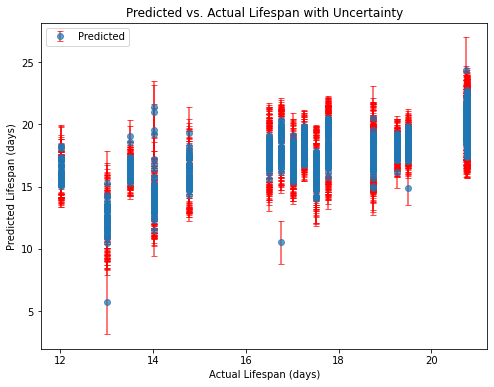

In [86]:
model, mse, r2 = predict_lifespan2(data, model_select="linear")

Mean Squared Error: 4.22
R^2 Score: 0.38

Feature Importances:
average_distance_per_frame: 0.1892
average_angular_speed: 0.1801
roaming_fraction: 0.1639
average_acceleration: 0.0780
std/mean: 0.0757
total_distance_traveled: 0.0659
id: 0.0429
std_speed: 0.0373
average_change_in_pixels: 0.0350
distance_traveled_bin: 0.0313
average_speed: 0.0273
group: 0.0271
maximal_distance_traveled: 0.0247
time_elapsed_(hours): 0.0217


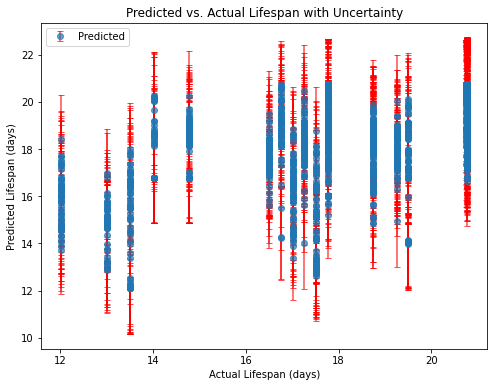

In [87]:
model, mse, r2 = predict_lifespan2(data, model_select="random_forest")

Mean Squared Error: 3.87
R^2 Score: 0.43

Feature Importances:
roaming_fraction: 0.3591
average_distance_per_frame: 0.1696
average_acceleration: 0.1378
total_distance_traveled: 0.0733
std/mean: 0.0518
id: 0.0406
group: 0.0329
time_elapsed_(hours): 0.0297
distance_traveled_bin: 0.0288
std_speed: 0.0286
maximal_distance_traveled: 0.0255
average_change_in_pixels: 0.0224
average_speed: 0.0000
average_angular_speed: 0.0000


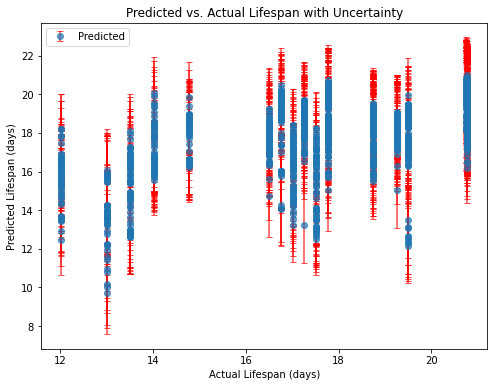

In [88]:
model, mse, r2 = predict_lifespan2(data, model_select="xgboost")

Mean Squared Error: 3.98
R^2 Score: 0.41

Feature Importances (Linear Regression Coefficients):
roaming_fraction: 0.0510
std_speed: 0.0451
average_acceleration: 0.0144
total_distance_traveled: -0.0001
average_distance_per_frame: -0.0001
average_angular_speed: -0.0000
id: 0.0000
group: 0.0000
average_speed: 0.0000
maximal_distance_traveled: 0.0000
average_change_in_pixels: 0.0000
distance_traveled_bin: 0.0000
time_elapsed_(hours): 0.0000
std/mean: 0.0000


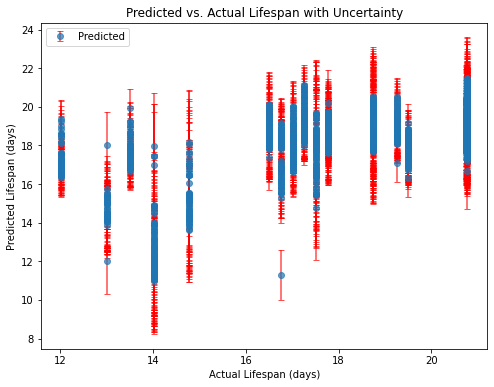

In [89]:
model, mse, r2 = predict_lifespan2(data, model_select="elasticnet")

Mean Squared Error: 5.99
R^2 Score: 0.11


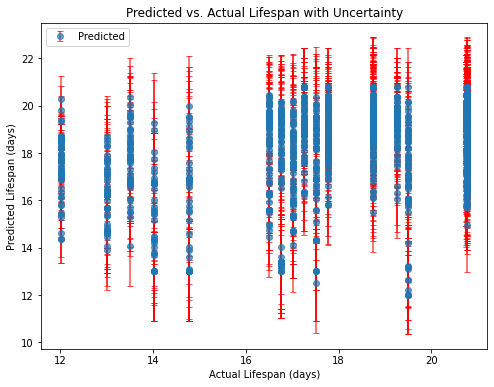

In [90]:
model, mse, r2 = predict_lifespan2(data, model_select="knr")

Mean Squared Error: 6.50
R^2 Score: 0.04


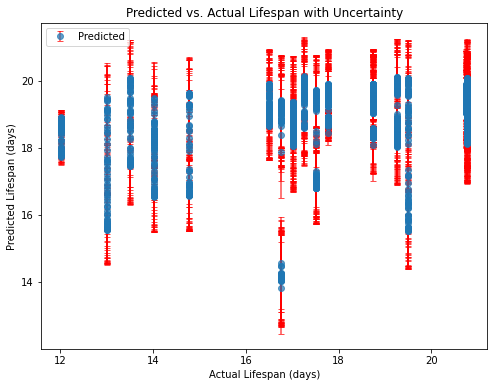

In [91]:
model, mse, r2 = predict_lifespan2(data, model_select="svr")